In [2]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sc
import numpy as np

In [2]:
sns.set(font='DejaVu Sans',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'grid.color': '.8',
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":10,
                                "axes.titlesize":12,
                                "axes.labelsize":10})
sns.set_palette("colorblind")

In [3]:
# Load data set
dataset = sc.io.loadmat('./Dataset1.mat')

In [4]:
# Retrieve data
data = dataset['R']
direction = dataset['direction'].reshape(158,)

## Visualize data (for fun)

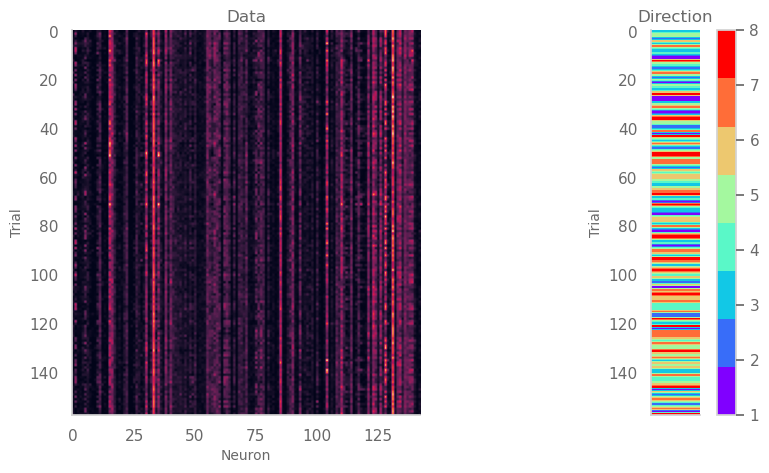

In [5]:
colors = plt.cm.rainbow(np.linspace(0, 1, 8))
cmap = ListedColormap(colors)


fig = plt.figure(figsize = (9,5))
fig.subplots_adjust(wspace = 0)

plt.subplot(121)

plt.imshow(data.T)
plt.xlabel('Neuron')
plt.ylabel('Trial')
plt.title('Data')

plt.subplot(122)
plt.imshow(direction.reshape(158,1), aspect = 0.05, cmap = cmap)
plt.title('Direction')
plt.ylabel('Trial')
plt.xticks([])
plt.colorbar()

plt.show()

## Mean firing rate of first neuron at each direction 
Error bars ar `sd` and `sem`, respectively

In [6]:
meanFiring = []
sdFiring = []
seFiring = []
for i in range(1, 9): # Moving along 'directions'
    # data[0] is the first neuron at i direction
    meanFiring.append(np.mean(data[0][direction == i]))
    sdFiring.append(np.std(data[0][direction == i]))
    seFiring.append(sc.stats.sem(data[0][direction == i]))

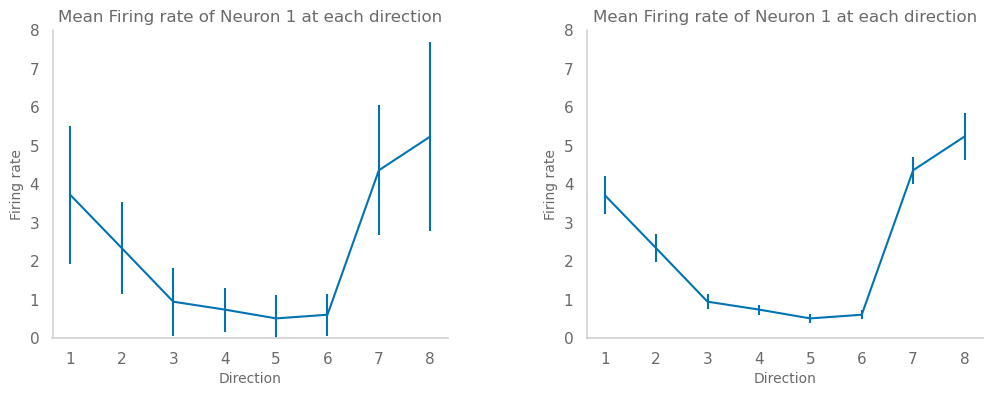

In [7]:
fig = plt.figure(figsize = (12,4))
fig.subplots_adjust(hspace=0.4, wspace=0.35)

plt.subplot(121)

plt.errorbar([i + 1 for i in range(8)], meanFiring, yerr = sdFiring)
plt.title('Mean Firing rate of Neuron 1 at each direction')
plt.xlabel('Direction')
plt.ylabel('Firing rate')
plt.ylim(0, 8)

plt.subplot(122)
plt.errorbar([i + 1for i in range(8)], meanFiring, yerr = seFiring)
plt.title('Mean Firing rate of Neuron 1 at each direction')
plt.xlabel('Direction')
plt.ylabel('Firing rate')
plt.ylim(0, 8)

plt.show()

## Mean firing rate of first nine neurons at each direction
Error bars are `sd`

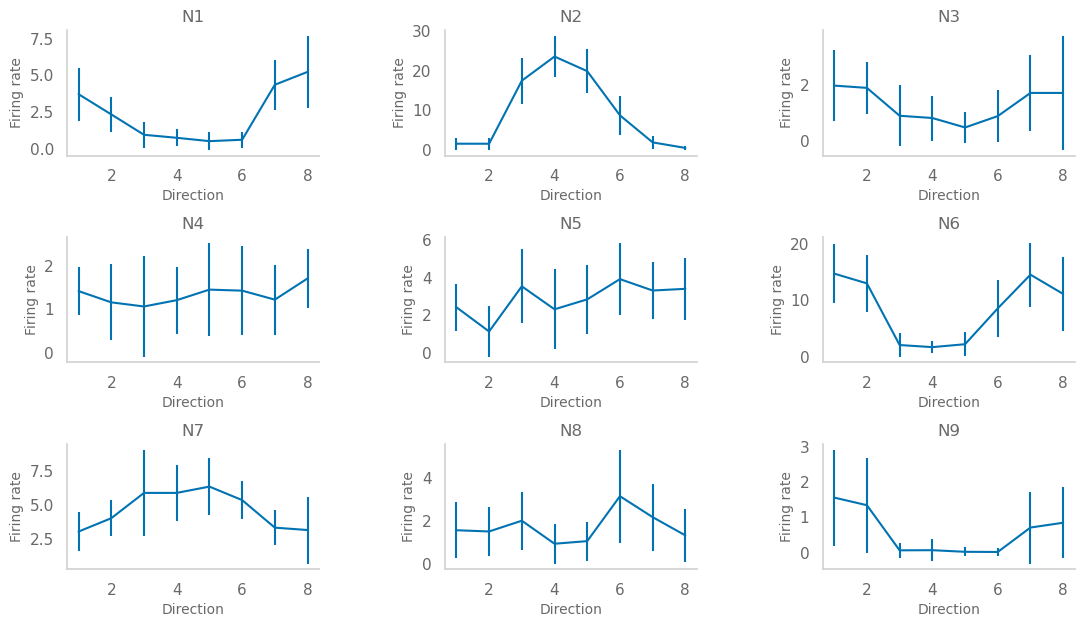

In [8]:
fig = plt.figure(figsize = (13,7))
fig.subplots_adjust(hspace = 0.65, wspace = 0.5)

# Same logic as previous chunk, but now, moving along first 9 neurons
for i in range(9):
    plt.subplot(331 + i)
    meanFiring = []
    sdFiring = []
    for j in range(1, 9):
        meanFiring.append(np.mean(data[i][direction == j]))
        sdFiring.append(np.std(data[i][direction == j]))
        seFiring.append(sc.stats.sem(data[i][direction == j]))
    plt.errorbar([k for k in range(1, 9)], meanFiring, yerr = sdFiring)
    plt.title('N{}'.format(i + 1))
    #plt.title('Mean Firing rate N{} \n for each direction'.format(i + 1))
    plt.xlabel('Direction')
    plt.ylabel('Firing rate')
    #plt.ylim(0, 8)
plt.show()

## Quantifying the uncertainty in the firing rate via Bootstrapping

In [9]:
nNeurons = data.shape[0]
nTrials = data.shape[1]
nBootstraps = 1e4

# Bootstrapping
firingRate_Bootstraps = []
for i in range(int(nBootstraps)):
    # Randomly select subset of 'Trials' with replacement
    bootstrapIndices = np.random.choice(nTrials, size = nTrials, replace = True)
    bootstrapData = data[:, bootstrapIndices]
    bootstrapDirection = direction[bootstrapIndices]
    
    # Calculate firing rate for each neuron for each direction
    firingRate_Bootstrap = []
    for d in range(1, 9):
        selectedTrials = bootstrapData[:, bootstrapDirection == d]
        firingRate = np.mean(selectedTrials, axis = 1)
        firingRate_Bootstrap.append(firingRate)
    
    firingRate_Bootstraps.append(firingRate_Bootstrap)
    
# Convert to np.array to easy on the statistics
firingRate_Bootstraps = np.array(firingRate_Bootstraps)

# Get statistics
meanFiring_rate = np.mean(firingRate_Bootstraps, axis = 0)
stdFiring_rate = np.std(firingRate_Bootstraps, axis = 0)
confidenceInterval = np.percentile(firingRate_Bootstraps, q = [2.5, 97.5], axis = 0)

## Visualize bootrapped values for first nine neurons

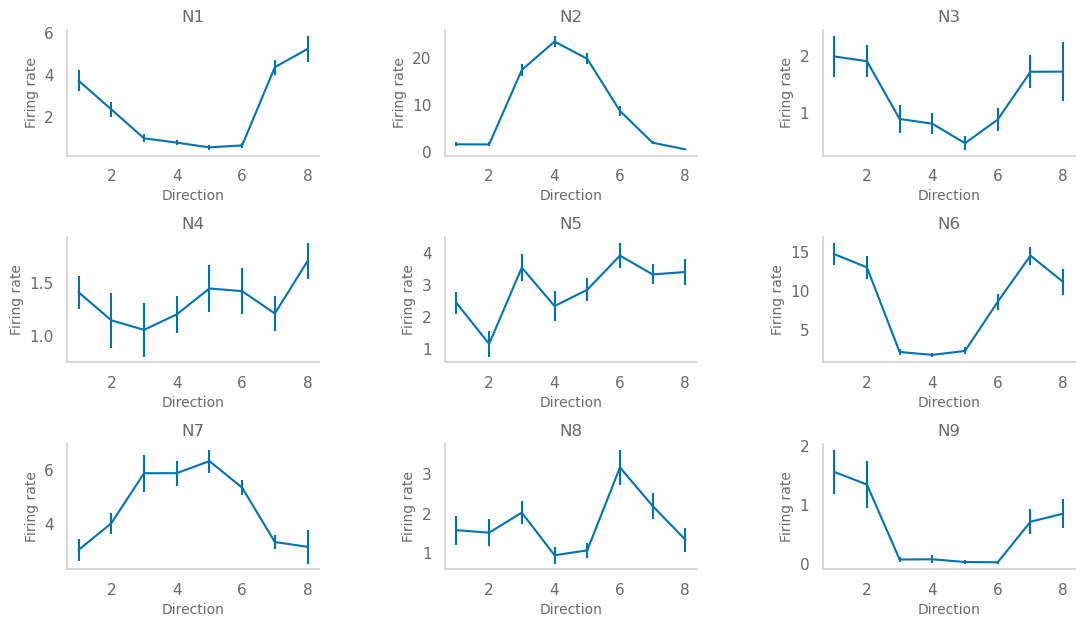

In [10]:
fig = plt.figure(figsize = (13,7))
fig.subplots_adjust(hspace = 0.65, wspace = 0.5)

# Same logic as previous chunk, but now, moving along first 9 neurons

for neuron in range(9):
    plt.subplot(331 + neuron)
    plt.errorbar([i + 1 for i in range(8)], meanFiring_rate[:, neuron], yerr = stdFiring_rate[:, neuron])
    plt.title('N{}'.format(neuron + 1))
    #plt.title('Mean Firing rate N{} \n for each direction'.format(i + 1))
    plt.xlabel('Direction')
    plt.ylabel('Firing rate')
    #plt.ylim(0, 8)
plt.show()

### Converting our data to DF

In [11]:
data_Bootstraped = []
for neuron in range(nNeurons):
    for d in range(8):
        data_Bootstraped.append({
            'Neuron': neuron + 1,
            'Direction': d + 1,
            'Mean': meanFiring_rate[d, neuron],
            'Std': stdFiring_rate[d, neuron],
            'CI_Low (0.025)': confidenceInterval[0, d, neuron],
            'CI_High (0.975)': confidenceInterval[1, d, neuron]})

df = pd.DataFrame(data_Bootstraped)

In [12]:
df.head(16)

,Neuron,Direction,Mean,Std,CI_Low (0.025),CI_High (0.975)
0,1,1,3.717931,0.499245,2.768539,4.734460
1,1,2,2.341287,0.356238,1.603183,3.038114
2,1,3,0.950171,0.193259,0.586075,1.335122
3,1,4,0.745156,0.130135,0.490555,1.011361
4,1,5,0.516263,0.121254,0.293676,0.768421
5,1,6,0.610814,0.114105,0.403849,0.854455
6,1,7,4.365464,0.354200,3.722565,5.114854
7,1,8,5.242244,0.622714,4.080650,6.501475
8,2,1,1.535852,0.437287,0.769127,2.483387
9,2,2,1.523346,0.443288,0.785922,2.504869


In [13]:
df.tail(16)

,Neuron,Direction,Mean,Std,CI_Low (0.025),CI_High (0.975)
1128,142,1,1.080737,0.186980,0.736693,1.462599
1129,142,2,0.622605,0.153632,0.321277,0.922980
1130,142,3,1.516732,0.235552,1.076824,1.988616
1131,142,4,1.235557,0.176091,0.904792,1.601218
1132,142,5,1.094617,0.129197,0.848954,1.357014
1133,142,6,0.779353,0.132854,0.532438,1.061449
1134,142,7,0.641520,0.090488,0.466155,0.816156
1135,142,8,0.622350,0.186450,0.272129,1.008334
1136,143,1,4.312417,0.583320,3.202669,5.480683
1137,143,2,2.704676,0.437202,1.840027,3.551222


## Neuron 1 vs Neuron 2

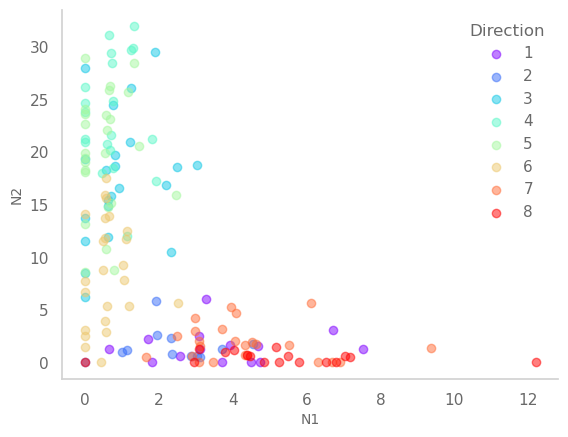

In [31]:
n1, n2 = 0, 1
for i in range(1, 9):
    plt.scatter(data[n1][direction == i], data[n2][direction == i], alpha = 0.5, label = '{}'.format(i), color = colors[i - 1])
plt.xlabel('N{}'.format(n1 + 1))
plt.ylabel('N{}'.format(n2 + 1))
plt.legend(title = 'Direction', frameon = False)
plt.show()

## PCA

But before... Standarization

In [20]:
scaler = StandardScaler()
scaledData = scaler.fit_transform(data.T) # Should I transpose? After one dim inconsistency, I did

Proceed with the PCA

In [16]:
nComponents = 10
pca = PCA(n_components = nComponents)
pca.fit(scaledData)

PCA(n_components=10)

In [17]:
# Transform the scaled data to the principal components
data_t = pca.transform(scaledData)

# Explained variance ratio of each component
explained_variance_ratio = pca.explained_variance_ratio_

# Principal components (eigenvectors)
principal_components = pca.components_

# Singular values
singular_values = pca.singular_values_

# Print the results
print(principal_components)
print("Singular Values:", singular_values)
print("Transformed Data Shape:", data_t.shape)

[[-0.14521606  0.18212999 -0.0896054  ...  0.05998513  0.0626239
  -0.11767804]
 [ 0.03879126  0.00709344  0.02425239 ... -0.07091999  0.0702461
  -0.02795611]
 [ 0.00063474  0.01160091  0.00637067 ...  0.0187989   0.11904894
  -0.02892554]
 ...
 [ 0.02621782  0.02165273  0.0043588  ...  0.03313063  0.05322798
  -0.08950989]
 [ 0.05556452  0.03738182 -0.04889627 ...  0.06453341 -0.10422507
   0.11266149]
 [-0.04197928 -0.03520853 -0.16969946 ...  0.1445975  -0.06006787
  -0.03032125]]
Singular Values: [61.94757771 36.2626671  33.6820685  31.10413136 25.67713294 23.36378782
 22.13662208 21.00045481 20.6768925  20.31658294]
Transformed Data Shape: (158, 10)


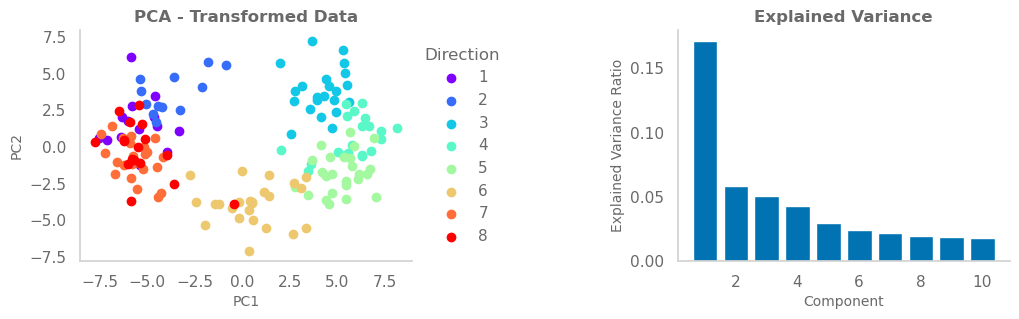

In [18]:
fig = plt.figure(figsize = (12,3))
fig.subplots_adjust(wspace = 0.8)

plt.subplot(121)
for d in range(8):
    mask = (direction == d + 1)
    plt.scatter(data_t[mask, 0], data_t[mask, 1], color = colors[d], label = '{}'.format(d + 1))

plt.title('PCA - Transformed Data', fontweight = 'bold')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc = 'center', bbox_to_anchor = (1.15, 0.5), title = 'Direction', frameon = False)

plt.subplot(122)
plt.bar([i + 1 for i in range(nComponents)], pca.explained_variance_ratio_)
plt.title('Explained Variance', fontweight = 'bold')
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [23]:
pca.explained_variance_ratio_[:2].sum()

0.22965249641351987

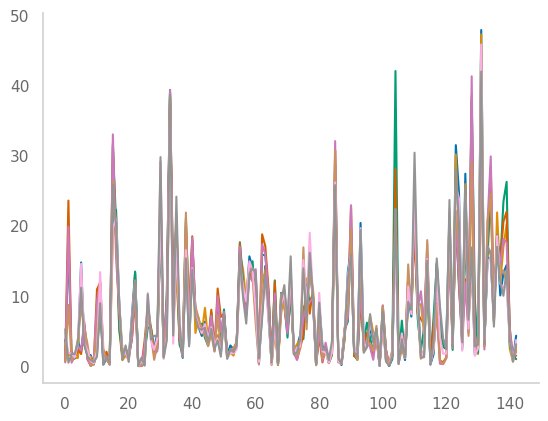

In [29]:
for i in range(8):
    plt.plot(data[:, direction == i + 1].mean(axis = 1))
plt.show()